In [32]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt

In [42]:
camera_matrix = np.array([[2892.07091, 0.00000000e+00, 2003.92607],
       [0.00000000e+00, 2895.418, 1454.19411],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype = "double")

# 扭曲係數

dist_coeffs = np.zeros((4,1)) # 假設沒有鏡頭的成像扭曲 (no lens distortion)


In [43]:
class FaceMesh():

    def __init__(self, batch_size=1, kpt_num=478):

        base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
        options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
        self.detector = vision.FaceLandmarker.create_from_options(options)
        self.kpt_num = kpt_num
        self.batch_size = batch_size
        self.error_idx = 0

        self.features_idx = [130, 133, 362, 359, 6, 195, 4, 61, 291]

    def detect(
        self,
        img,
        type=None,
        exp=None,
        camID=None,
    ):
        features = np.zeros((len(self.features_idx), 2))
        # Convert the BGR image to RGB before processing.
        tmp_kpt = np.zeros((self.kpt_num, 2))
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
        results = self.detector.detect(img)
        for face_landmark in results.face_landmarks:
            for idx, data_point in enumerate(face_landmark):
                tmp_kpt[idx, 0] = data_point.x * img.width
                tmp_kpt[idx, 1] = data_point.y * img.height

        for idx, feat in enumerate(self.features_idx):
            features[idx] = tmp_kpt[feat]
                
        return features
    
mp_detect = FaceMesh()

W0000 00:00:1698837351.308043    8882 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [44]:
point_9 = [{"x":1.1487776041030884,"y":0.5863138437271118,"z":0.1841275990009308},{"x":0.6536890864372253,"y":0.7021274566650391,"z":-0.28791943192481995},{"x":0.1392146348953247,"y":0.7623808979988098,"z":-0.571087658405304},{"x":-0.5424240231513977,"y":0.8541930913925171,"z":-0.713115394115448},{"x":0.5681824684143066,"y":0.8439069986343384,"z":-0.674114465713501},{"x":0.6105332374572754,"y":0.5397124886512756,"z":-0.8868389129638672},{"x":0.6783662438392639,"y":0.2753174901008606,"z":-1.164299726486206},{"x":0.7586176991462708,"y":-0.672084391117096,"z":-0.5813802480697632},{"x":-0.09441086649894714,"y":-0.47917985916137695,"z":-1.064441204071045}]
#point 9 x,y,z
point_9 = np.array([[point3d['x'],point3d['y'],point3d['z']] for point3d in point_9])

In [45]:
#Read 2D image
img = cv2.imread('/home/aaron/Desktop/head_pose.jpg')
kpt9 = mp_detect.detect(img)

In [46]:
for i, kpt in enumerate(kpt9):
    kpt = kpt.astype(np.int32)
    cv2.circle(img, (kpt[0], kpt[1]), 10, (255, 0, 0), -1)
    cv2.putText(img, str(i), (kpt[0], kpt[1]),cv2.FONT_HERSHEY_SIMPLEX,
  2, (0, 255, 255), 1, cv2.LINE_AA)
cv2.namedWindow('test', cv2.WINDOW_NORMAL)
cv2.imshow('test', img)
key = cv2.waitKey(0)
if key ==27:
    cv2.destroyAllWindows()

In [47]:
# 使用OpenCV的solvePnP函數來計算人臉的旋轉與位移
#(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix
#                                                              , dist_coeffs, flags=cv2.CV_ITERATIVE)
# 參數:
#   model_points 3維模型的座標點
#   image_points 2維圖像的座標點
#   camera_matrix 照像機矩陣
#   dist_coeffs 照像機扭曲係數
#   flags: cv2.SOLVEPNP_ITERATIVE
model_points=point_9
face_points = kpt9

(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                              , dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

R = cv2.Rodrigues(rotation_vector)[0]
t = translation_vector


print("Rotation Vector:\n {0}".format(R)) # 旋轉向量
print("Translation Vector:\n {0}".format(t)) # 位移向量

Rotation Vector:
 [[-0.74311797  0.25533091 -0.61853199]
 [ 0.01883496 -0.91599296 -0.40075197]
 [-0.66889531 -0.30945602  0.67588168]]
Translation Vector:
 [[-2.80927284]
 [ 2.38227779]
 [14.84828363]]


In [48]:
# 計算歐拉角
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6]

yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]

if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

抬頭(+)/低頭(-) [pitch]:  [155.39907318]
右轉(+)/左轉(-) [yaw]  :  [41.98186136]
右傾(+)/左傾(-) [roll] :  [-178.5481001]


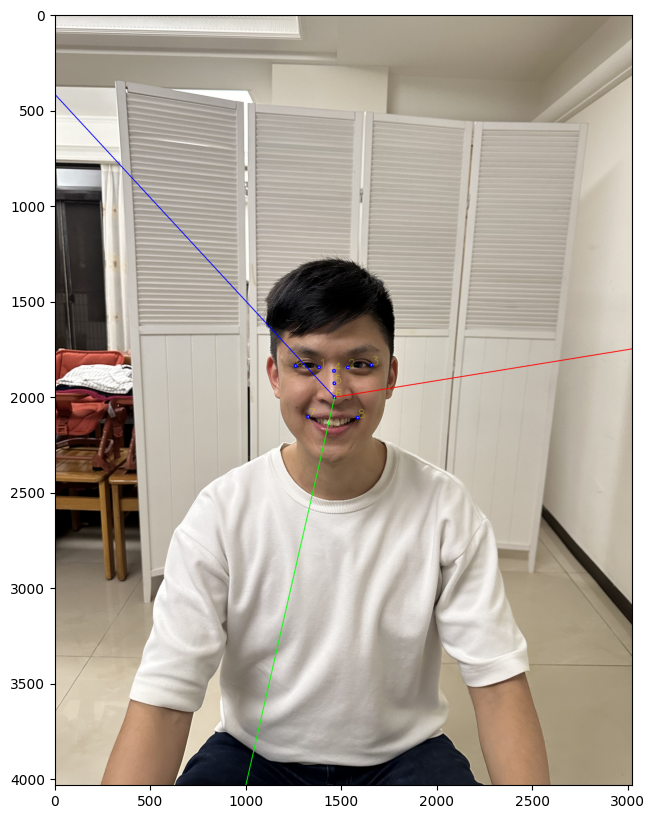

抬頭(+)/低頭(-) [pitch]:  [155.39907318]
右轉(+)/左轉(-) [yaw]  :  [41.98186136]
右傾(+)/左傾(-) [roll] :  [-178.5481001]


In [49]:
# 投射一個3D的點 (100.0, 0, 0)到2D圖像的座標上
(x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 100.0, 0)到2D圖像的座標上
(y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 0, 100.0)到2D圖像的座標上
(z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                           , translation_vector, camera_matrix, dist_coeffs)


# 以 Nose tip為中心點畫出x, y, z的軸線
p_nose = (int(face_points[6][0]), int(face_points[6][1]))

p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

cv2.line(img, p_nose, p_x, (0,0,255), 3)  # X軸 (紅色)
cv2.line(img, p_nose, p_y, (0,255,0), 3)  # Y軸 (綠色)
cv2.line(img, p_nose, p_z, (255,0,0), 3)  # Z軸 (藍色)

# 把6個基準點標註出來
for p in face_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# 秀出圖像
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # 從BGR -> RGB
plt.show()

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)
